In [57]:
import os
import numpy as np
import tensorflow as tf
import sklearn
import pylab  
import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import nibabel as nib
import math
import random
import time
from scipy import ndimage
from sklearn.metrics import f1_score
from scipy.spatial.distance import directed_hausdorff
import numpy as np
import csv
%matplotlib inline

In [29]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
def npmin(dd):
    return np.min(dd)
def npmax(dd):
    return np.max(dd)
def npmean(dd):
    return np.mean(dd)
def norm (data):
    return (data - npmin(data)) / (npmax(data) - npmin(data))*1

In [30]:
isTrain = True
checkpoint_dir = "checkpoint"
epoch = 50
batch_size = 1
output_class_num = 4

In [31]:
def scale_3d(src, md='nearest'):
    depth=128
    height=128
    width=128
    out = ndimage.zoom(src,(depth/src.shape[0],height/src.shape[1],width/src.shape[2]),mode = md,order = 0)
    return out

In [32]:
def value2onehot(label):
#     label = label[...,np.newaxis]
#     label = np.repeat(label, output_class_num+1, axis=3)
    l0=[]
    for i in range(label.shape[0]):
        l1=[]
        for j in range(label.shape[1]):
            l2=[]
            for k in range(label.shape[2]):
                if label[i,j,k]==0:
                    l2.append([1,0,0,0])
                elif label[i,j,k]==0.25:
                    l2.append([0,1,0,0])
                elif label[i,j,k]==0.5:
                    l2.append([0,0,1,0])
                elif label[i,j,k]==1:
                    l2.append([0,0,0,1])
            l1.append(l2)
        l0.append(l1)
    l0 = np.asarray(l0, dtype=np.uint8)
    #print(l0.shape)
    return l0

def onehot2value(label_batch):
    l0_batch=[]
    #for l in range(label_batch.shape[0]):
    label = label_batch
    l0=[]
    for i in range(label.shape[0]):
        l1=[]
        for j in range(label.shape[1]):
            l2=[]
            for k in range(label.shape[2]):
                if np.argmax(label[i,j,k])==0:
                    l2.append(0)
                elif np.argmax(label[i,j,k])==1:
                    l2.append(0.25)
                    #print('!!',label[i,j,k])
                elif np.argmax(label[i,j,k])==2:
                    l2.append(0.5)
                    #print('!!',label[i,j,k])
                elif np.argmax(label[i,j,k])==3:
                    l2.append(1)
                    #print('!!',label[i,j,k])
            l1.append(l2)
        l0.append(l1)

    l0_batch = np.asarray(l0)
    #print(l0_batch.shape)
    return l0_batch

In [33]:
def f1score(gt, seg):
    if (np.sum(seg) + np.sum(gt)) == 0:
        return 1.0
    else:
        return np.sum(np.multiply(gt,seg))*2.0 / (np.sum(seg) + np.sum(gt))
def evaluation_return(y_true, y_pred):
    dim = len(y_true.shape)
    score=[]
    hausdorff=[]
    for k in range(y_true.shape[dim-1]):
        f1 = f1score(y_true[...,k], y_pred[...,k])
        score.append(f1)
        sym_hausdorff = max(directed_hausdorff(y_true[...,k],y_pred[...,k])[0], directed_hausdorff(y_pred[...,k],y_true[...,k])[0])
        hausdorff.append(sym_hausdorff)
    score = np.asarray(score)
    hausdorff = np.asarray(hausdorff)

#     flat_true = np.asarray(flat_true)
#     flat_pred = np.asarray(flat_pred)
#     sym_hausdorff = max(directed_hausdorff(flat_true[1:],flat_pred[1:])[0], directed_hausdorff(flat_pred[1:],flat_true[1:])[0])
    return np.mean(score[1:]), np.mean(hausdorff[1:])

def evaluation(y_true, y_pred):
    dim = len(y_true.shape)
    score=[]
    for k in range(y_true.shape[dim-1]):
        f1 = f1score(y_true[...,k], y_pred[...,k])
        score.append(f1)
        print ('type',k ,'f1 score is',f1)
    score = np.asarray(score)
    print('whole f1 score is',np.mean(score[1:]))

def mse(A,B):
    mse = ((A - B)**2).mean(axis=None)
    return mse


In [10]:

filedir = "../MICCAI_BraTS_2018_Data_Training/HGG/"
#filepath += "ct_train_1001_image.nii"

train_data = os.listdir(filedir)
train_array = []
t1ce_train_array = []
seg_array = []
for d in train_data:
    #print(d)
    nii_dir = os.path.join(filedir, d)
    nii_file = os.listdir(nii_dir)
    for n in nii_file:
        #print(n)
        if n.split(".")[0].split("_")[-1] == 't1ce' or n.split(".")[0].split("_")[-1] == 'seg' or n.split(".")[0].split("_")[-1] == 'flair':
            filepath = os.path.join(nii_dir, n)
            nii = nib.load(filepath)
            #print("load", filepath)
            img_array = nii.get_data()
            affine_array = nii.affine 
            img_head = nii.header
            #print(img_array.shape)
            img_array = img_array.transpose(0, 2, 1)
            img_array = img_array.transpose(1, 0, 2)
            nii_CT = img_array
            nii_CT = np.asarray(nii_CT)
            nii_CT = np.rot90(nii_CT,axes=(1,2))
            #print(nii_CT.shape)
            norm_nii_CT = nii_CT
            norm_nii_CT = norm(norm_nii_CT)

            #print(np.max(nii_CT),np.min(nii_CT))
            #print(np.max(norm_nii_CT),np.min(norm_nii_CT))
            if n.split(".")[0].split("_")[-1] == 't1ce':
                t1ce_train_array.append(norm_nii_CT)
            elif n.split(".")[0].split("_")[-1] == 'flair':
                train_array.append(norm_nii_CT)
            elif n.split(".")[0].split("_")[-1] == 'seg':
                seg_array.append(norm_nii_CT)
t1ce_train_array = np.array(t1ce_train_array)
print(t1ce_train_array.shape)
train_array = np.array(train_array)
print(train_array.shape)
seg_array = np.array(seg_array)
print(seg_array.shape)
np.save('t1ce_train_array', t1ce_train_array)
np.save('flair_train_array', train_array)
np.save('seg_array', seg_array)

/home/yunyun/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


(210, 155, 240, 240)
(210, 155, 240, 240)
(210, 155, 240, 240)


In [11]:
# back_check_label = onehot2value(onehot_nii_label)
# print(np.max(back_check_label),np.min(back_check_label))

In [7]:
input_height = 128 #onehot_nii_label.shape[1]
input_width = 128 #onehot_nii_label.shape[2]
input_depth = 128

In [14]:
flair_nii_CT = np.load('./flair_train_array.npy')
t1ce_nii_CT = np.load('./t1ce_train_array.npy')
print(flair_nii_CT.shape)
print(t1ce_nii_CT.shape)

(210, 155, 240, 240)
(210, 155, 240, 240)


In [15]:
nii_label = np.load('./seg_array.npy')
print(nii_label.shape)

(210, 155, 240, 240)


In [16]:
shuff= np.arange(40)
np.random.shuffle(shuff)
print(shuff)

[ 0 15  6 36  9 33 12 13 14  5 20 11  2 32 26 34  8  1 27 18  3 22 24 23
 16 28 25 10  4 39 29 19 30 35 38 17 37 31 21  7]


In [17]:
small_nii_CT = np.concatenate((flair_nii_CT[:20], t1ce_nii_CT[:20]),axis=0)
small_nii_label = np.concatenate((nii_label[:20], nii_label[:20]), axis=0)
print(small_nii_CT.shape)
print(small_nii_label.shape)

small_nii_CT = small_nii_CT[shuff]
small_nii_label = small_nii_label[shuff]

n1 = []
n2 = []
for i in range(small_nii_CT.shape[0]):
    image1 = scale_3d(small_nii_CT[i])
    image2 = scale_3d(small_nii_label[i])
    n1.append(image1)
    n2.append(image2)
resize_nii_CT = np.asarray(n1[:35])
resize_nii_label = np.asarray(n2[:35])
valid_nii_CT = np.asarray(n1[35:])
valid_nii_label = np.asarray(n2[35:])
print(resize_nii_CT.shape)
print(resize_nii_label.shape)
print(valid_nii_CT.shape)
print(valid_nii_label.shape)

(40, 155, 240, 240)
(40, 155, 240, 240)
(35, 128, 128, 128)
(35, 128, 128, 128)
(5, 128, 128, 128)
(5, 128, 128, 128)


In [18]:
# value to onehot
onehot_array = []
onehot_array2 = []
for i in range(resize_nii_label.shape[0]):
    onehot_nii_label = value2onehot(resize_nii_label[i])
    onehot_array.append(onehot_nii_label)

for i in range(valid_nii_label.shape[0]):
    onehot_nii_label = value2onehot(valid_nii_label[i])
    onehot_array2.append(onehot_nii_label)    

train_onehot_array = np.asarray(onehot_array, dtype=np.uint8)
valid_onehot_array = np.asarray(onehot_array2, dtype=np.uint8)

In [21]:
#check onehot to value
value_array = []
value_array2 = []
for i in range(train_onehot_array.shape[0]):
    value_nii_label = onehot2value(train_onehot_array[i])
    value_array.append(value_nii_label)
for i in range(valid_onehot_array.shape[0]):
    value_nii_label = onehot2value(valid_onehot_array[i])
    value_array2.append(value_nii_label)
value_array = np.asarray(value_array)
value_array2 = np.asarray(value_array2)
print(np.sum(value_array-resize_nii_label))
print(np.sum(value_array2-valid_nii_label))

0.0
0.0


In [13]:
print(train_onehot_array.shape)
print(valid_onehot_array.shape)

(35, 128, 128, 128, 4)
(5, 128, 128, 128, 4)


Flair CT nii image: 



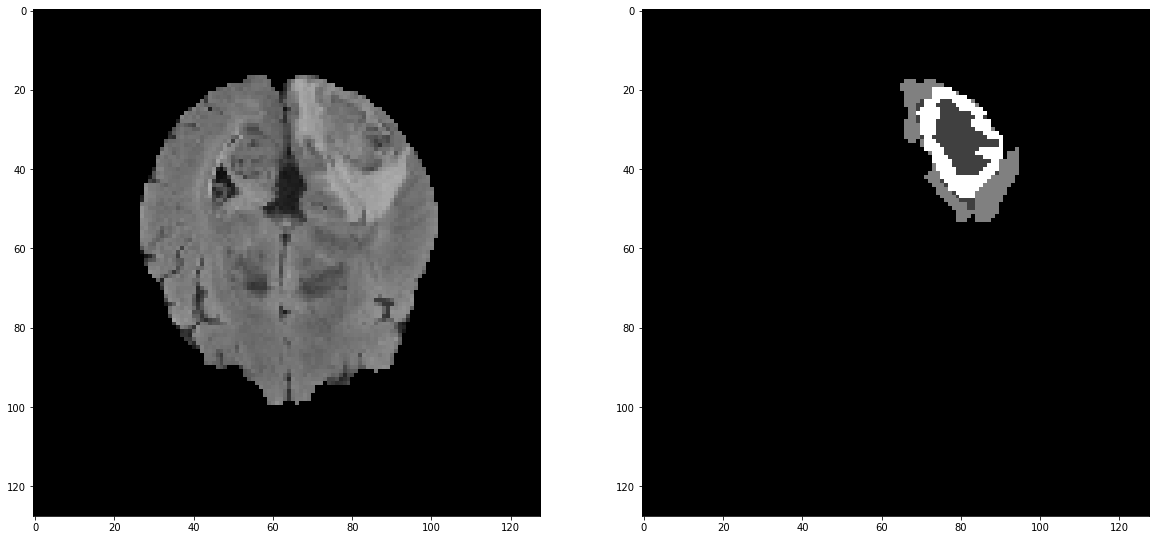

0.6802096985583224 0.0
1.0 0.0


In [34]:
tt = 0
sl_num = 50
'''
ROIrx = 180
ROIry = 200
ROIbx = 300
ROIby = 110
ROIs = 15
'''
print('Flair CT nii image: \n')
fig = plt.figure(figsize=(20, 20))
fig.add_subplot(1,2,1)
plt.imshow(resize_nii_CT[tt][sl_num],cmap=pylab.cm.gray,vmin = 0,vmax = 1)
fig.add_subplot(1,2,2)
#rect = patches.Rectangle((ROIrx,ROIry),ROIs,ROIs,linewidth=1,edgecolor='r',facecolor='none')
#plt.gca().add_patch(rect)
#rect = patches.Rectangle((ROIbx,ROIby),ROIs,ROIs,linewidth=1,edgecolor='b',facecolor='none')
#plt.gca().add_patch(rect)
plt.imshow(resize_nii_label[tt][sl_num],cmap=pylab.cm.gray,vmin = 0,vmax = 1)
# fig.add_subplot(1,3,3)
# plt.imshow(norm(back_check_label)[tt],cmap=pylab.cm.gray,vmin = 0,vmax = 1)
plt.show()

print(np.max(resize_nii_CT[tt][sl_num]),np.min(resize_nii_CT[tt][sl_num]))
print(np.max(resize_nii_label[tt][sl_num]),np.min(resize_nii_label[tt][sl_num]))

#print("red ROI",np.mean(nii_label[tt][50,ROIry:ROIry+ROIs,ROIrx:ROIrx+ROIs]),
#      np.std(nii_label[tt][50,ROIry:ROIry+ROIs,ROIrx:ROIrx+ROIs]))
#print("blue ROI",np.mean(nii_label[tt][50,ROIby:ROIby+ROIs,ROIbx:ROIbx+ROIs]),
#      np.std(nii_label[tt][50,ROIby:ROIby+ROIs,ROIbx:ROIbx+ROIs]))

t1ne CT nii image: 



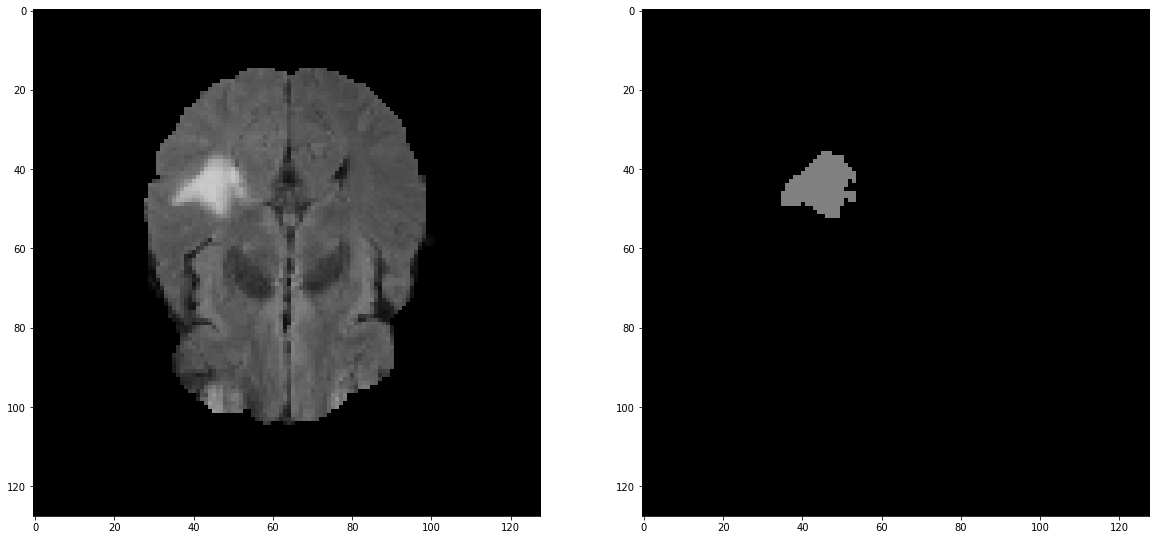

0.7955314827352742 0.0
0.5 0.0


In [35]:
tt = 1
sl_num = 50

print('t1ne CT nii image: \n')
fig = plt.figure(figsize=(20, 20))
fig.add_subplot(1,2,1)
plt.imshow(resize_nii_CT[tt][sl_num],cmap=pylab.cm.gray,vmin = 0,vmax = 1)
fig.add_subplot(1,2,2)
#rect = patches.Rectangle((ROIrx,ROIry),ROIs,ROIs,linewidth=1,edgecolor='r',facecolor='none')
#plt.gca().add_patch(rect)
#rect = patches.Rectangle((ROIbx,ROIby),ROIs,ROIs,linewidth=1,edgecolor='b',facecolor='none')
#plt.gca().add_patch(rect)
plt.imshow(resize_nii_label[tt][sl_num],cmap=pylab.cm.gray,vmin = 0,vmax = 1)
# fig.add_subplot(1,3,3)
# plt.imshow(norm(back_check_label)[tt],cmap=pylab.cm.gray,vmin = 0,vmax = 1)
plt.show()

print(np.max(resize_nii_CT[tt][sl_num]),np.min(resize_nii_CT[tt][sl_num]))
print(np.max(resize_nii_label[tt][sl_num]),np.min(resize_nii_label[tt][sl_num]))

In [36]:
from keras.layers import UpSampling3D, Conv3D, MaxPool3D, ReLU

def Conv3d(input, ch, f, pad= 'same', act = 'leakyrelu'):
    with tf.name_scope("Unet"):
        x = input
        x = Conv3D(ch, 3, padding = pad, use_bias=True)(x)
        if act == 'relu':
            x = tf.nn.relu(x)
        elif act == 'sigmoid':
            x = tf.sigmoid(x)
        elif act == 'leakyrelu':
            x = tf.nn.leaky_relu(x, alpha = 0.01)
        return x

def MaxPool3d(input, ps):
    x = input
    x = MaxPool3D(pool_size=ps, strides=ps)(x)
    return x

def Upsample3d(input, scale):
    x = input
    x = UpSampling3D(size = (scale,scale,scale), data_format ="channels_last")(x)
    return x

def Deconv3d(input, ch, upscale, batch, xdim, ydim, zdim, pad= 'SAME'):
    x = input
    x = Conv3DTranspose(x, filter=tf.constant(np.ones([upscale,upscale,upscale,ch,ch], np.float32)),
                               output_shape=[batch, xdim, ydim, zdim, ch],
                                strides=[1, upscale, upscale, upscale, 1],
                                padding= pad)
#     x = tf.layers.conv3d_transpose(x, ch, f, strides = [2,2,2], padding = pad, kernel_initializer=tf.contrib.layers.xavier_initializer(), use_bias=True)
    return x

def Unet(placeholders, batch):
    #decode
   
    x = placeholders['input']
    print("Input",x)
    x = Conv3d(x, 64, 3)
    x = Conv3d(x, 64, 3)
    conv1 = x
    x = MaxPool3d(x, 2)
    print("Conv1", conv1)
    
    x = Conv3d(x, 128, 3)
    x = Conv3d(x, 128, 3)
    conv2 = x
    x = MaxPool3d(x, 2)
    print("Conv2", conv2)
    
    x = Conv3d(x, 256, 3)
    x = Conv3d(x, 256, 3)
    conv3 = x
    x = MaxPool3d(x, 2)
    print("Conv3", conv3)
    
    x = Conv3d(x, 512, 3)
    x = Conv3d(x, 512, 3)
    conv4 = x
    x = MaxPool3d(x, 2)
    print("Conv4", conv4)
    
    #encode
    x = Conv3d(x, 512, 3)
    x = Conv3d(x, 512, 3)
    conv5 = x
    print("Conv5", conv5)
#     x = Deconv3d(x, 512, 2, batch, input_depth//8, input_height//8, input_width//8)
    x = Upsample3d(x,2)
    print("Upsample5", x)
    x = tf.concat([x, conv4], axis = 4)
    merge5 = x
    print("Merge5", merge5)
    
    x = Conv3d(x, 256, 3)
    x = Conv3d(x, 256, 3)
    conv6 = x
    print("Conv6", conv6)
#     x = Deconv3d(x, 256, 2, batch, input_depth//4, input_height//4, input_width//4)
    x = Upsample3d(x,2)
    x = tf.concat([x, conv3], axis = 4)
    merge6 = x
    print("Merge6", merge6)
    
    x = Conv3d(x, 128, 3)
    x = Conv3d(x, 128, 3)
    conv7 = x
    print("Conv7", conv7)
#     x = Deconv3d(x, 128, 2, batch, input_depth//2, input_height//2, input_width//2)
    x = Upsample3d(x,2)
    x = tf.concat([x, conv2], axis = 4)
    merge7 = x
    print("Merge7", merge7)
    
    x = Conv3d(x, 64, 3)
    x = Conv3d(x, 64, 3)
    conv8 = x
    print("Conv8", conv8)
#     x = Deconv3d(x, 64, 2, batch, input_depth, input_height, input_width)
    x = Upsample3d(x,2)
    x = tf.concat([x, conv1], axis = 4)
    merge8 = x
    print("Merge8", merge8)
    
    x = Conv3d(x, 32, 3)
    x = Conv3d(x, 32, 3)
    x = Conv3d(x, output_class_num, 1)
    conv9 = x
    print("Conv9", conv9)
    
    return x
    
    

In [41]:
placeholders = {
    'input': tf.placeholder(tf.float32,shape=(None,input_depth,input_height,input_width,1)),
    'label': tf.placeholder(tf.float32,shape=(None,input_depth,input_height,input_width,output_class_num))
}


#with tf.variable_scope('Unet_model') as scope:
Unet_out_tensor = Unet(placeholders, batch_size)

Input Tensor("Placeholder_4:0", shape=(?, 128, 128, 128, 1), dtype=float32)
Conv1 Tensor("Unet_39/LeakyRelu:0", shape=(?, 128, 128, 128, 64), dtype=float32)
Conv2 Tensor("Unet_41/LeakyRelu:0", shape=(?, 64, 64, 64, 128), dtype=float32)
Conv3 Tensor("Unet_43/LeakyRelu:0", shape=(?, 32, 32, 32, 256), dtype=float32)
Conv4 Tensor("Unet_45/LeakyRelu:0", shape=(?, 16, 16, 16, 512), dtype=float32)
Conv5 Tensor("Unet_47/LeakyRelu:0", shape=(?, 8, 8, 8, 512), dtype=float32)
Upsample5 Tensor("up_sampling3d_9/concat_2:0", shape=(?, 16, 16, 16, 512), dtype=float32)
Merge5 Tensor("concat_8:0", shape=(?, 16, 16, 16, 1024), dtype=float32)
Conv6 Tensor("Unet_49/LeakyRelu:0", shape=(?, 16, 16, 16, 256), dtype=float32)
Merge6 Tensor("concat_9:0", shape=(?, 32, 32, 32, 512), dtype=float32)
Conv7 Tensor("Unet_51/LeakyRelu:0", shape=(?, 32, 32, 32, 128), dtype=float32)
Merge7 Tensor("concat_10:0", shape=(?, 64, 64, 64, 256), dtype=float32)
Conv8 Tensor("Unet_53/LeakyRelu:0", shape=(?, 64, 64, 64, 64), dtyp

In [42]:
def focal_loss(pred, label):
    '''
    :param pred: B,N,num_class
    :param label: B,N
    :return: float
    '''
    label = tf.to_float(label)
    num_class = 4
    pred_soft = tf.nn.softmax(pred)
    #label_onehot = tf.one_hot(label, depth=num_class, dtype=tf.float32)
    probs = pred_soft * label  # (b, n, n_c)
    probs = tf.reduce_sum(probs, axis=-1)  # (b, n)
    focal_loss = -tf.pow((1-probs), 5.0) * tf.log(probs)
    loss = tf.reduce_mean(focal_loss)
    return loss

cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=placeholders['label'],logits=Unet_out_tensor))

#bce = tf.keras.losses.BinaryCrossentropy()
#bce_loss = bce(placeholders['label'], Unet_out_tensor)
f_loss = focal_loss(Unet_out_tensor, placeholders['label'])

out_softmax = tf.nn.softmax(Unet_out_tensor)
softmax_label = tf.nn.softmax(placeholders['label'])
mse_loss = tf.losses.mean_squared_error(softmax_label,out_softmax)
#print(mse_loss.shape)
sub_value = softmax_label-out_softmax
#print(sub_value.shape)
a = sub_value[:,:,:,:,0]*0.05
b = sub_value[:,:,:,:,1]*0.2
c = sub_value[:,:,:,:,2]*0.15
d = sub_value[:,:,:,:,3]*0.6
weight_value = tf.stack([a, b, c, d], axis=-1)
weighted_mse_loss = tf.reduce_mean(weight_value**2)
#print(weighted_mse_loss.shape)
inse = tf.reduce_sum(out_softmax * softmax_label)
l = tf.reduce_sum(out_softmax)
r = tf.reduce_sum(softmax_label)
dice = (2. * inse + 1e-5) / (l + r + 1e-5)
dice = tf.reduce_mean(dice)
dice_loss = (1-dice)

loss = weighted_mse_loss

In [43]:

variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Unet_model')
trainer = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [44]:


saver = tf.train.Saver()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [45]:
data_3d = resize_nii_CT
label_3d = train_onehot_array 
print(label_3d.shape)

'''
data_3d=[]
label_3d=[]
for i in range(data.shape[0]//input_depth):
    for j in range(data.shape[1]//input_height):
        for k in range(data.shape[2]//input_width):
            data_3d.append(data[i*input_depth:(i+1)*input_depth,j*input_height:(j+1)*input_height,k*input_width:(k+1)*input_width])
            label_3d.append(label[i*input_depth:(i+1)*input_depth,j*input_height:(j+1)*input_height,k*input_width:(k+1)*input_width])

data_3d = np.asarray(data_3d)
label_3d = np.asarray(label_3d)
'''
print(data_3d.shape)
print(label_3d.shape)

(35, 128, 128, 128, 4)
(35, 128, 128, 128)
(35, 128, 128, 128, 4)


In [46]:
loss_list=[]
valid_loss_in_epoch = []
if isTrain:
    nowtime = time.time()
    for e in range(epoch):
        print("Epoch ",e," Current time: ", time.ctime())
        sel = np.arange((int)(data_3d.shape[0]/batch_size))
        np.random.shuffle(sel)
        iteration = (int)(data_3d.shape[0]/batch_size)
        loss_in_epoch = []            
        loss_v = []
        for it in range(iteration):

            input_batch = []
            label_batch = []
            for b in range(batch_size):
                input_batch.append(data_3d[sel[it*batch_size+b]])
                label_batch.append(label_3d[sel[it*batch_size+b]])
            input_batch = np.asarray(input_batch).reshape([batch_size,input_depth,input_height,input_width,1])
            label_batch = np.asarray(label_batch).reshape([batch_size,input_depth,input_height,input_width,output_class_num])

            feed_dict=dict()
            feed_dict.update({placeholders['input']:input_batch})
            feed_dict.update({placeholders['label']:label_batch})

            outs = sess.run([trainer, loss, Unet_out_tensor],feed_dict=feed_dict)
            
            cur_loss = outs[1]

            print("Epoch", e, "Iteration", it)
            print("Loss:", cur_loss)
            loss_in_epoch.append(cur_loss)
        loss_list.append(np.mean(loss_in_epoch))
        if(e%1==0):

            for i in range(valid_nii_CT.shape[0]):
            #         print("Testing batch ", i)

                input_batch = valid_nii_CT[i]  
                label_batch = valid_onehot_array[i]

                feed_dict=dict()
                feed_dict.update({placeholders['input']:input_batch.reshape(1,input_depth,input_height,input_width,1)})
                feed_dict.update({placeholders['label']:label_batch.reshape(1,input_depth,input_height,input_width,output_class_num)})
                # print valid loss
                outs = sess.run([loss, Unet_out_tensor],feed_dict=feed_dict)
                loss_v.append(outs[0])
                
            valid_loss_in_epoch.append(np.mean(loss_v))
            print("Valid loss: {}".format(np.mean(loss_v)))
            #logger.info("Valid loss: {loss_v}".format(loss_v = np.mean(valid_loss)))
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        saver.save(sess, "./"+checkpoint_dir+"/"+"Unet_epoch_"+str(e)+".ckpt")


Epoch  0  Current time:  Sun Jun 21 22:01:54 2020
Epoch 0 Iteration 0
Loss: 0.0006728807
Epoch 0 Iteration 1
Loss: 0.0006428072
Epoch 0 Iteration 2
Loss: 0.0006364543
Epoch 0 Iteration 3
Loss: 0.0006378792
Epoch 0 Iteration 4
Loss: 0.0006264175
Epoch 0 Iteration 5
Loss: 0.0006065521
Epoch 0 Iteration 6
Loss: 0.00059579586
Epoch 0 Iteration 7
Loss: 0.00057430624
Epoch 0 Iteration 8
Loss: 0.00055925397
Epoch 0 Iteration 9
Loss: 0.0004915631
Epoch 0 Iteration 10
Loss: 0.0004256758
Epoch 0 Iteration 11
Loss: 0.0005673651
Epoch 0 Iteration 12
Loss: 0.00033551798
Epoch 0 Iteration 13
Loss: 0.0003080081
Epoch 0 Iteration 14
Loss: 0.00029859724
Epoch 0 Iteration 15
Loss: 0.00029331734
Epoch 0 Iteration 16
Loss: 0.00022054548
Epoch 0 Iteration 17
Loss: 0.00017539668
Epoch 0 Iteration 18
Loss: 0.0003349824
Epoch 0 Iteration 19
Loss: 0.00019130818
Epoch 0 Iteration 20
Loss: 0.00019338058
Epoch 0 Iteration 21
Loss: 0.00020841396
Epoch 0 Iteration 22
Loss: 0.00018717715
Epoch 0 Iteration 23
Loss: 0

Epoch 5 Iteration 17
Loss: 1.1439394e-05
Epoch 5 Iteration 18
Loss: 4.6269015e-06
Epoch 5 Iteration 19
Loss: 4.047981e-06
Epoch 5 Iteration 20
Loss: 4.2187457e-05
Epoch 5 Iteration 21
Loss: 4.183932e-05
Epoch 5 Iteration 22
Loss: 1.3620641e-05
Epoch 5 Iteration 23
Loss: 2.2279377e-05
Epoch 5 Iteration 24
Loss: 2.8349938e-05
Epoch 5 Iteration 25
Loss: 1.5406851e-05
Epoch 5 Iteration 26
Loss: 8.2157e-06
Epoch 5 Iteration 27
Loss: 4.3990367e-06
Epoch 5 Iteration 28
Loss: 1.2071764e-05
Epoch 5 Iteration 29
Loss: 2.5230273e-05
Epoch 5 Iteration 30
Loss: 3.9898794e-05
Epoch 5 Iteration 31
Loss: 3.5112364e-05
Epoch 5 Iteration 32
Loss: 2.7574493e-05
Epoch 5 Iteration 33
Loss: 1.5165047e-05
Epoch 5 Iteration 34
Loss: 2.90573e-05
Valid loss: 3.172888682456687e-05
Instructions for updating:
Use standard file APIs to delete files with this prefix.
Epoch  6  Current time:  Sun Jun 21 22:06:31 2020
Epoch 6 Iteration 0
Loss: 4.2038464e-05
Epoch 6 Iteration 1
Loss: 1.2424056e-05
Epoch 6 Iteration 2
L

Epoch 10 Iteration 26
Loss: 2.3912506e-05
Epoch 10 Iteration 27
Loss: 4.1943324e-05
Epoch 10 Iteration 28
Loss: 3.745509e-05
Epoch 10 Iteration 29
Loss: 6.651653e-05
Epoch 10 Iteration 30
Loss: 3.06693e-05
Epoch 10 Iteration 31
Loss: 4.036729e-06
Epoch 10 Iteration 32
Loss: 1.1604955e-05
Epoch 10 Iteration 33
Loss: 2.6444346e-05
Epoch 10 Iteration 34
Loss: 3.272808e-05
Valid loss: 3.069291415158659e-05
Epoch  11  Current time:  Sun Jun 21 22:10:13 2020
Epoch 11 Iteration 0
Loss: 3.284521e-05
Epoch 11 Iteration 1
Loss: 7.151776e-06
Epoch 11 Iteration 2
Loss: 4.1143227e-05
Epoch 11 Iteration 3
Loss: 1.0047699e-05
Epoch 11 Iteration 4
Loss: 6.395062e-05
Epoch 11 Iteration 5
Loss: 3.170438e-06
Epoch 11 Iteration 6
Loss: 3.0049987e-06
Epoch 11 Iteration 7
Loss: 3.777558e-05
Epoch 11 Iteration 8
Loss: 6.4532364e-06
Epoch 11 Iteration 9
Loss: 3.3525255e-06
Epoch 11 Iteration 10
Loss: 2.5915751e-05
Epoch 11 Iteration 11
Loss: 4.2519874e-05
Epoch 11 Iteration 12
Loss: 6.42216e-06
Epoch 11 Itera

Epoch 16 Iteration 2
Loss: 3.0630625e-05
Epoch 16 Iteration 3
Loss: 3.7621012e-05
Epoch 16 Iteration 4
Loss: 1.0242598e-05
Epoch 16 Iteration 5
Loss: 2.9444633e-05
Epoch 16 Iteration 6
Loss: 3.8492868e-05
Epoch 16 Iteration 7
Loss: 2.24768e-05
Epoch 16 Iteration 8
Loss: 1.0252785e-05
Epoch 16 Iteration 9
Loss: 3.6262467e-05
Epoch 16 Iteration 10
Loss: 4.1906154e-05
Epoch 16 Iteration 11
Loss: 3.0043971e-05
Epoch 16 Iteration 12
Loss: 7.2702437e-06
Epoch 16 Iteration 13
Loss: 3.165414e-06
Epoch 16 Iteration 14
Loss: 3.786936e-05
Epoch 16 Iteration 15
Loss: 4.090028e-05
Epoch 16 Iteration 16
Loss: 2.4541634e-05
Epoch 16 Iteration 17
Loss: 3.3655902e-05
Epoch 16 Iteration 18
Loss: 4.0091792e-05
Epoch 16 Iteration 19
Loss: 3.172355e-06
Epoch 16 Iteration 20
Loss: 6.4046685e-06
Epoch 16 Iteration 21
Loss: 1.3757712e-05
Epoch 16 Iteration 22
Loss: 4.0931745e-06
Epoch 16 Iteration 23
Loss: 6.065295e-06
Epoch 16 Iteration 24
Loss: 1.0697197e-05
Epoch 16 Iteration 25
Loss: 6.203333e-05
Epoch 16

Epoch 21 Iteration 15
Loss: 2.992559e-06
Epoch 21 Iteration 16
Loss: 3.7920538e-05
Epoch 21 Iteration 17
Loss: 4.011027e-05
Epoch 21 Iteration 18
Loss: 3.221383e-05
Epoch 21 Iteration 19
Loss: 2.2417578e-05
Epoch 21 Iteration 20
Loss: 9.875181e-06
Epoch 21 Iteration 21
Loss: 1.1597042e-05
Epoch 21 Iteration 22
Loss: 3.1555814e-05
Epoch 21 Iteration 23
Loss: 7.0122082e-06
Epoch 21 Iteration 24
Loss: 1.1099156e-05
Epoch 21 Iteration 25
Loss: 3.5618035e-05
Epoch 21 Iteration 26
Loss: 2.9052642e-05
Epoch 21 Iteration 27
Loss: 3.970531e-06
Epoch 21 Iteration 28
Loss: 5.8173864e-05
Epoch 21 Iteration 29
Loss: 3.2388375e-06
Epoch 21 Iteration 30
Loss: 2.3787596e-05
Epoch 21 Iteration 31
Loss: 4.226598e-06
Epoch 21 Iteration 32
Loss: 1.9526295e-05
Epoch 21 Iteration 33
Loss: 3.865869e-05
Epoch 21 Iteration 34
Loss: 2.8514645e-05
Valid loss: 2.7286116164759733e-05
Epoch  22  Current time:  Sun Jun 21 22:18:21 2020
Epoch 22 Iteration 0
Loss: 2.8978298e-05
Epoch 22 Iteration 1
Loss: 6.2607096e-06

Epoch 26 Iteration 28
Loss: 1.1144522e-05
Epoch 26 Iteration 29
Loss: 2.4041667e-05
Epoch 26 Iteration 30
Loss: 5.8803316e-06
Epoch 26 Iteration 31
Loss: 3.9185936e-05
Epoch 26 Iteration 32
Loss: 1.8201887e-05
Epoch 26 Iteration 33
Loss: 3.5547335e-05
Epoch 26 Iteration 34
Loss: 2.8769803e-06
Valid loss: 2.7732199669117108e-05
Epoch  27  Current time:  Sun Jun 21 22:22:03 2020
Epoch 27 Iteration 0
Loss: 1.1385543e-05
Epoch 27 Iteration 1
Loss: 7.5745274e-06
Epoch 27 Iteration 2
Loss: 3.5440912e-06
Epoch 27 Iteration 3
Loss: 2.913473e-05
Epoch 27 Iteration 4
Loss: 3.4525765e-05
Epoch 27 Iteration 5
Loss: 3.85431e-06
Epoch 27 Iteration 6
Loss: 2.926867e-05
Epoch 27 Iteration 7
Loss: 2.8231401e-05
Epoch 27 Iteration 8
Loss: 2.1229966e-06
Epoch 27 Iteration 9
Loss: 1.0262441e-05
Epoch 27 Iteration 10
Loss: 3.7773298e-05
Epoch 27 Iteration 11
Loss: 5.5457305e-05
Epoch 27 Iteration 12
Loss: 1.3955083e-05
Epoch 27 Iteration 13
Loss: 1.0800385e-05
Epoch 27 Iteration 14
Loss: 9.485699e-06
Epoch

Epoch 32 Iteration 4
Loss: 5.919614e-06
Epoch 32 Iteration 5
Loss: 2.2666306e-06
Epoch 32 Iteration 6
Loss: 3.8948932e-05
Epoch 32 Iteration 7
Loss: 1.1623193e-05
Epoch 32 Iteration 8
Loss: 5.3960935e-06
Epoch 32 Iteration 9
Loss: 1.914707e-06
Epoch 32 Iteration 10
Loss: 2.7336373e-05
Epoch 32 Iteration 11
Loss: 1.8780129e-05
Epoch 32 Iteration 12
Loss: 3.0650954e-05
Epoch 32 Iteration 13
Loss: 1.0471716e-05
Epoch 32 Iteration 14
Loss: 3.8115577e-06
Epoch 32 Iteration 15
Loss: 3.3111686e-05
Epoch 32 Iteration 16
Loss: 1.9187937e-05
Epoch 32 Iteration 17
Loss: 2.1186677e-05
Epoch 32 Iteration 18
Loss: 2.901548e-05
Epoch 32 Iteration 19
Loss: 3.986138e-06
Epoch 32 Iteration 20
Loss: 3.769874e-06
Epoch 32 Iteration 21
Loss: 2.3823502e-05
Epoch 32 Iteration 22
Loss: 9.449644e-06
Epoch 32 Iteration 23
Loss: 2.6322166e-05
Epoch 32 Iteration 24
Loss: 3.381771e-05
Epoch 32 Iteration 25
Loss: 6.3467146e-06
Epoch 32 Iteration 26
Loss: 3.2827553e-05
Epoch 32 Iteration 27
Loss: 3.6261983e-05
Epoch

Epoch 37 Iteration 17
Loss: 4.131334e-06
Epoch 37 Iteration 18
Loss: 1.8318082e-05
Epoch 37 Iteration 19
Loss: 3.7853333e-05
Epoch 37 Iteration 20
Loss: 7.89193e-06
Epoch 37 Iteration 21
Loss: 2.7259633e-05
Epoch 37 Iteration 22
Loss: 4.0645926e-05
Epoch 37 Iteration 23
Loss: 2.3752982e-05
Epoch 37 Iteration 24
Loss: 2.9326522e-05
Epoch 37 Iteration 25
Loss: 1.3277648e-05
Epoch 37 Iteration 26
Loss: 2.9019096e-05
Epoch 37 Iteration 27
Loss: 1.9257499e-05
Epoch 37 Iteration 28
Loss: 1.1160694e-05
Epoch 37 Iteration 29
Loss: 1.07593305e-05
Epoch 37 Iteration 30
Loss: 6.532221e-05
Epoch 37 Iteration 31
Loss: 1.3034008e-05
Epoch 37 Iteration 32
Loss: 1.3158806e-05
Epoch 37 Iteration 33
Loss: 3.70806e-06
Epoch 37 Iteration 34
Loss: 3.2378244e-05
Valid loss: 2.791843689919915e-05
Epoch  38  Current time:  Sun Jun 21 22:30:11 2020
Epoch 38 Iteration 0
Loss: 4.1166633e-05
Epoch 38 Iteration 1
Loss: 1.5067511e-05
Epoch 38 Iteration 2
Loss: 2.3478222e-05
Epoch 38 Iteration 3
Loss: 1.2118373e-05


Epoch 42 Iteration 30
Loss: 2.507111e-05
Epoch 42 Iteration 31
Loss: 2.857378e-06
Epoch 42 Iteration 32
Loss: 3.2021548e-05
Epoch 42 Iteration 33
Loss: 1.8009532e-05
Epoch 42 Iteration 34
Loss: 1.5019946e-05
Valid loss: 2.3198981580208056e-05
Epoch  43  Current time:  Sun Jun 21 22:33:53 2020
Epoch 43 Iteration 0
Loss: 3.2871543e-05
Epoch 43 Iteration 1
Loss: 1.8334913e-05
Epoch 43 Iteration 2
Loss: 1.8832086e-06
Epoch 43 Iteration 3
Loss: 7.3488704e-06
Epoch 43 Iteration 4
Loss: 3.669994e-05
Epoch 43 Iteration 5
Loss: 3.7906827e-06
Epoch 43 Iteration 6
Loss: 1.2322919e-05
Epoch 43 Iteration 7
Loss: 1.8808794e-05
Epoch 43 Iteration 8
Loss: 2.9621115e-06
Epoch 43 Iteration 9
Loss: 2.6714963e-05
Epoch 43 Iteration 10
Loss: 9.386067e-06
Epoch 43 Iteration 11
Loss: 2.4950645e-05
Epoch 43 Iteration 12
Loss: 4.4446842e-05
Epoch 43 Iteration 13
Loss: 3.104759e-05
Epoch 43 Iteration 14
Loss: 1.0359316e-05
Epoch 43 Iteration 15
Loss: 2.354636e-05
Epoch 43 Iteration 16
Loss: 2.4698578e-05
Epoch 

Epoch 48 Iteration 6
Loss: 3.229705e-05
Epoch 48 Iteration 7
Loss: 4.582542e-06
Epoch 48 Iteration 8
Loss: 1.5522255e-05
Epoch 48 Iteration 9
Loss: 1.8136701e-05
Epoch 48 Iteration 10
Loss: 8.670194e-06
Epoch 48 Iteration 11
Loss: 9.750468e-06
Epoch 48 Iteration 12
Loss: 2.485323e-05
Epoch 48 Iteration 13
Loss: 3.6981677e-05
Epoch 48 Iteration 14
Loss: 1.2912361e-05
Epoch 48 Iteration 15
Loss: 1.840819e-05
Epoch 48 Iteration 16
Loss: 6.572167e-06
Epoch 48 Iteration 17
Loss: 3.641912e-05
Epoch 48 Iteration 18
Loss: 2.7074118e-05
Epoch 48 Iteration 19
Loss: 2.0230656e-05
Epoch 48 Iteration 20
Loss: 1.4117498e-05
Epoch 48 Iteration 21
Loss: 2.7664146e-05
Epoch 48 Iteration 22
Loss: 1.0821823e-05
Epoch 48 Iteration 23
Loss: 5.442555e-06
Epoch 48 Iteration 24
Loss: 1.8187699e-05
Epoch 48 Iteration 25
Loss: 6.8859413e-06
Epoch 48 Iteration 26
Loss: 1.9600388e-05
Epoch 48 Iteration 27
Loss: 2.109707e-05
Epoch 48 Iteration 28
Loss: 1.2731704e-05
Epoch 48 Iteration 29
Loss: 3.847421e-06
Epoch 4

In [49]:
if isTrain:
    ti = time.time()-nowtime
    print("Training time: %d min, %d sec"% (ti/60, ti%60))

Training time: 39 min, 6 sec


(50,)


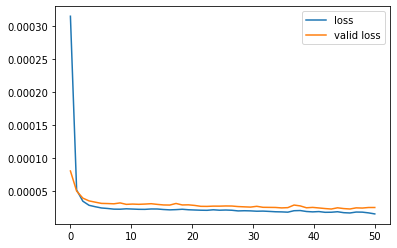

In [50]:
print(np.asarray(valid_loss_in_epoch).shape)
if isTrain:
    x = np.linspace(0,50,50)
    x1 = np.linspace(0,50,50)
    plt.plot(x, loss_list, label='loss')
    plt.plot(x1, valid_loss_in_epoch, label='valid loss')
    plt.legend(loc='upper right')
    plt.ticklabel_format(useOffset=False)
    plt.show()

In [51]:
test_dataset = data_3d
ground_truth = label_3d
#test_dataset = valid_nii_CT
#ground_truth = valid_nii_label
print(test_dataset.shape)
print(ground_truth.shape)
np.save('test_nii_data', data_3d)
np.save('test_nii_label', label_3d)

(35, 128, 128, 128)
(35, 128, 128, 128, 4)


In [52]:
nowtime = time.time()

with tf.Session() as session:
    if isTrain:
        saver.restore(session, "./"+checkpoint_dir+"/"+"Unet_epoch_"+str(50-1)+".ckpt")
    else:
        saver.restore(session, "./"+checkpoint_dir+"/"+"Unet_epoch_"+str(26)+".ckpt")
    print("Model restored.") 
    print('Initialized')

    for i in range(test_dataset.shape[0]):
        print("Testing batch ", i)
        test_image = test_dataset[i]
        feed_dict=dict()
        feed_dict.update({placeholders['input']:test_image.reshape(batch_size,input_depth,input_height,input_width,1)})

        gen = session.run(tf.nn.softmax(Unet_out_tensor),feed_dict=feed_dict)
    
        #print(np.unique(gen), np.unique(gen))
        gen = gen.reshape([input_depth,input_height,input_width,output_class_num])
        #print(gen[0][0])
        value_gen = onehot2value(gen)
        value_gen = value_gen.reshape([batch_size, input_depth,input_height,input_width])
        if i == 0 :
            test_output = value_gen
        else:
            test_output = np.concatenate((test_output,value_gen), axis = 0)
        
    
#         test_output = np.asarray(test_output)
        print("test_output size", test_output.shape)

ti = time.time()-nowtime
print("Testing time: %d min, %d sec"% (ti/60, ti%60))

INFO:tensorflow:Restoring parameters from ./checkpoint/Unet_epoch_49.ckpt
Model restored.
Initialized
Testing batch  0
test_output size (1, 128, 128, 128)
Testing batch  1
test_output size (2, 128, 128, 128)
Testing batch  2
test_output size (3, 128, 128, 128)
Testing batch  3
test_output size (4, 128, 128, 128)
Testing batch  4
test_output size (5, 128, 128, 128)
Testing batch  5
test_output size (6, 128, 128, 128)
Testing batch  6
test_output size (7, 128, 128, 128)
Testing batch  7
test_output size (8, 128, 128, 128)
Testing batch  8
test_output size (9, 128, 128, 128)
Testing batch  9
test_output size (10, 128, 128, 128)
Testing batch  10
test_output size (11, 128, 128, 128)
Testing batch  11
test_output size (12, 128, 128, 128)
Testing batch  12
test_output size (13, 128, 128, 128)
Testing batch  13
test_output size (14, 128, 128, 128)
Testing batch  14
test_output size (15, 128, 128, 128)
Testing batch  15
test_output size (16, 128, 128, 128)
Testing batch  16
test_output size (1

In [53]:
np.save('testing_result_flair_t1ne', test_output)

In [54]:
'''
print('Whole volume f1 score')
seg = output_onehot
gt = ground_truth_onehot
evaluation(gt, seg)
'''

output_onehot = []
for i in range(test_output.shape[0]):
    onehot_array = value2onehot(test_output[i])
    output_onehot.append(onehot_array)
output_onehot = np.asarray(output_onehot, dtype=np.uint8)
ground_truth_onehot = ground_truth


In [58]:
for idx in range(output_onehot.shape[0]):
    dice = []
    hausdorff = []
    for sl in range(output_onehot.shape[1]):
        seg = output_onehot[idx][sl]
        gt = ground_truth_onehot[idx][sl]
        d, h = evaluation_return(gt,seg)
        dice.append(d)
        hausdorff.append(h)

    dice = np.asarray(dice)
    print('patient idx: ', idx)
    print('dice shape: ',dice.shape)
    hausdorff = np.asarray(hausdorff)
    print('hausdorff shape: ', hausdorff.shape)
    print("Dice mean:", np.mean(dice), "STD:",np.std(dice))
    print("Hausdorff mean:", np.mean(hausdorff), "STD:",np.std(hausdorff))
    print("--------------------------------\n")
    with open('testing_output_flair_t1ne.csv', 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([idx, np.mean(dice), np.std(dice), np.mean(hausdorff), np.std(hausdorff)])

patient idx:  0
dice shape:  (128,)
hausdorff shape:  (128,)
Dice mean: 0.6807681304955998 STD: 0.3626141346451423
Hausdorff mean: 1.1700957085416546 STD: 1.4120922527458342
--------------------------------

patient idx:  1
dice shape:  (128,)
hausdorff shape:  (128,)
Dice mean: 0.7503674045562074 STD: 0.30961438617376574
Hausdorff mean: 0.8360020478613133 STD: 1.0572606068864172
--------------------------------

patient idx:  2
dice shape:  (128,)
hausdorff shape:  (128,)
Dice mean: 0.6426528530784501 STD: 0.39830315890859475
Hausdorff mean: 1.0157447730378293 STD: 1.195790954624197
--------------------------------

patient idx:  3
dice shape:  (128,)
hausdorff shape:  (128,)
Dice mean: 0.7617619287543653 STD: 0.3571505490020753
Hausdorff mean: 0.7539176039175626 STD: 1.1884598103100552
--------------------------------

patient idx:  4
dice shape:  (128,)
hausdorff shape:  (128,)
Dice mean: 0.8854166666666667 STD: 0.2714336295999038
Hausdorff mean: 0.2879575780421117 STD: 0.6850697809

In [25]:
for i in range(test_output.shape[0]):
    print(np.unique(test_output[i]))
    for j in range(128):
        for k in range(128):
            for l in range(128):
                if test_output[i,j,k,l]!=0:
                    test_output[i,j,k,l] = 1
    print(np.unique(test_output[i]))

[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25 0.5  1.  ]
[0. 1.]
[0.   0.25

Patient: 2
Segmentation resullts: 



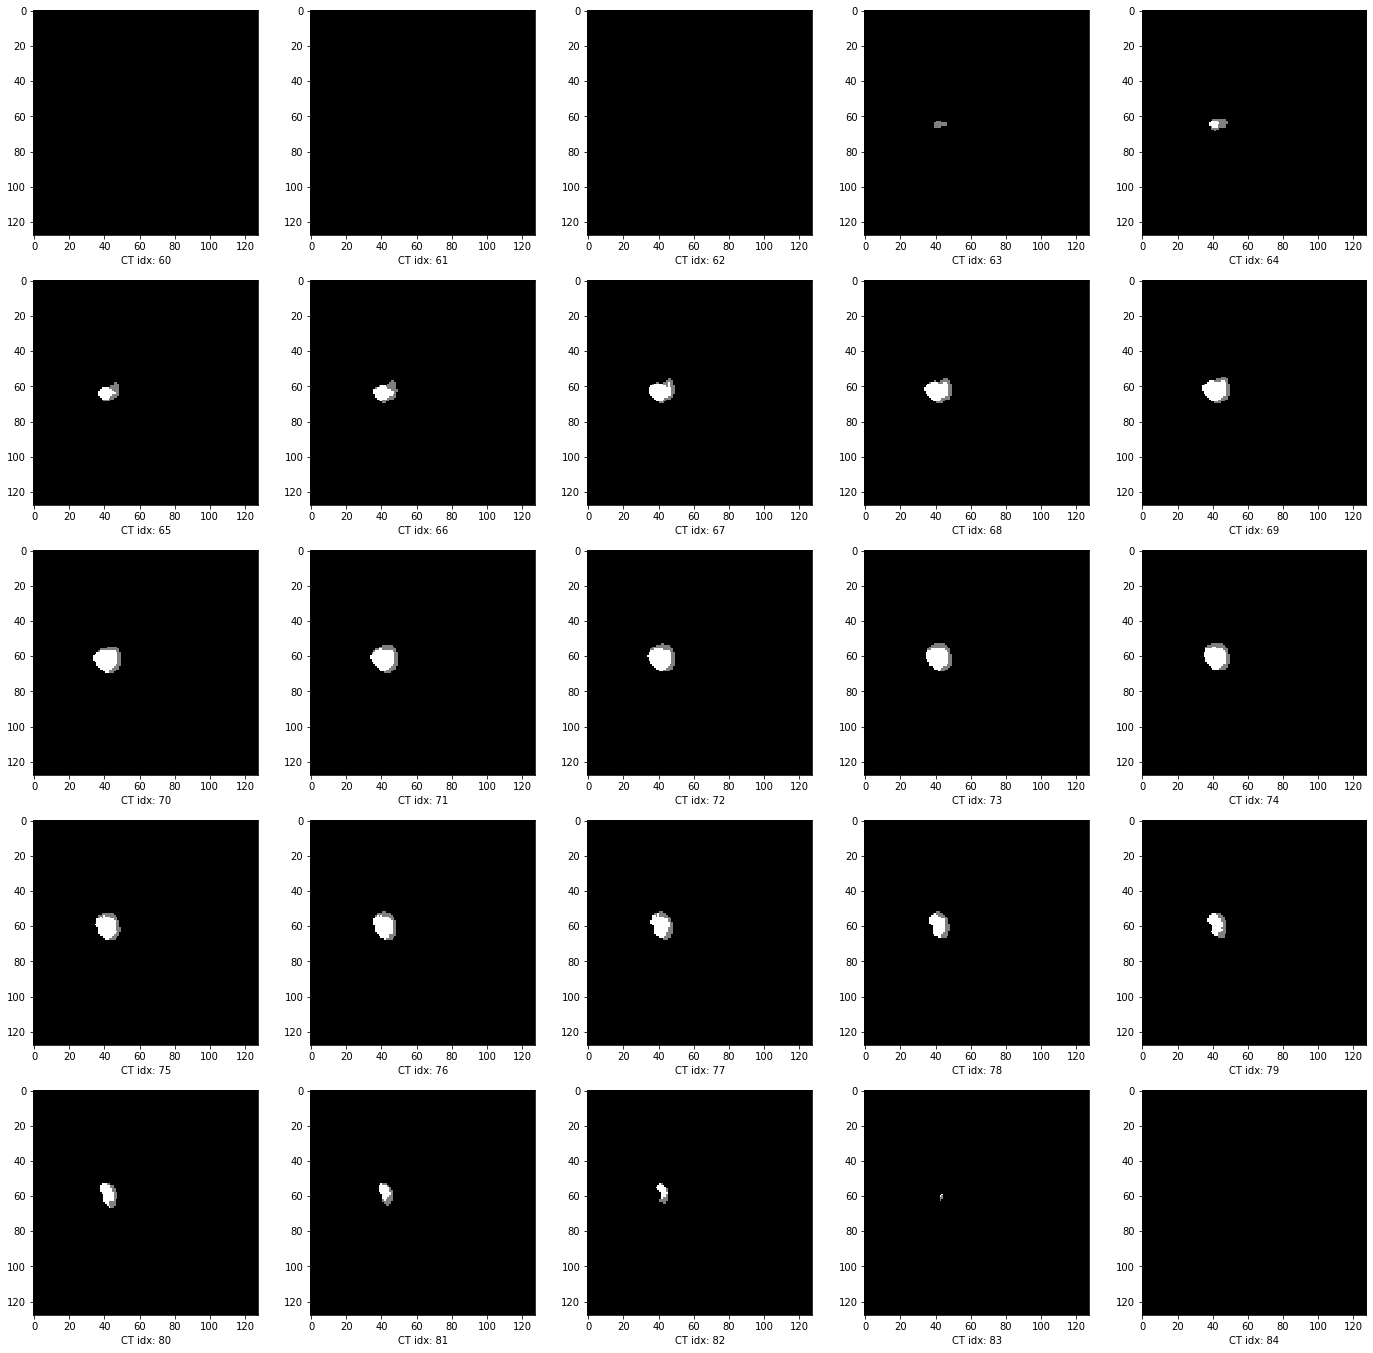

In [59]:
rows = 5
cols = 5
fig,ax = plt.subplots(rows,cols,figsize=[24,24])
num = 2
print('Patient: {}'.format(num))
print('Segmentation resullts: \n')
for i in range(rows*cols):
    #ind = start_with + i*show_every
    #ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
    ax[int(i/rows),int(i % rows)].imshow(test_output[num][i+60],cmap=pylab.cm.gray,vmin = 0,vmax = 1)
    #ax[int(i/rows),int(i % rows)].axis('off')
    ax[int(i/rows),int(i % rows)].set_xlabel('CT idx: {}'.format(i+60))
plt.show()

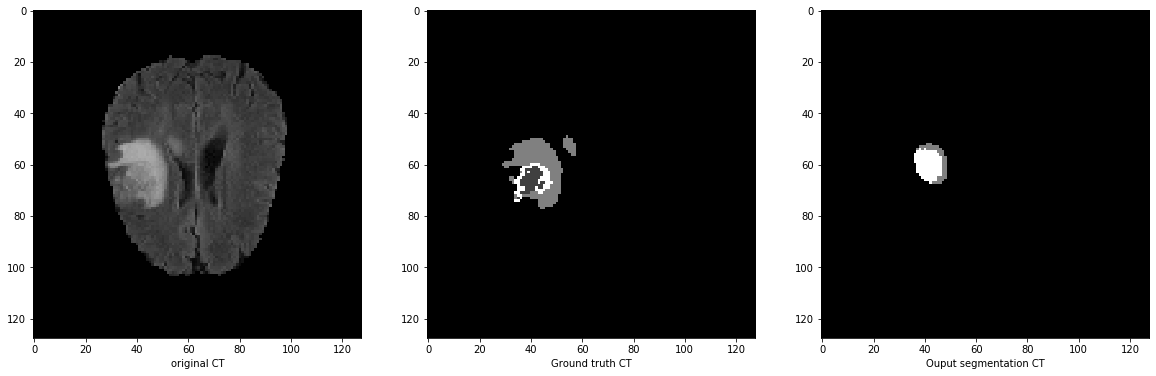

In [61]:
### flair CT model result
num=0
slice_num=50
fig = plt.figure(figsize=(20, 20))
fig.add_subplot(1,3,1)
plt.imshow(data_3d[num][slice_num],cmap=pylab.cm.gray,vmin = 0,vmax = 1)
plt.xlabel('original CT')
fig.add_subplot(1,3,2)
plt.imshow(resize_nii_label[num][slice_num],cmap=pylab.cm.gray,vmin = 0,vmax = 1)
plt.xlabel('Ground truth CT')
fig.add_subplot(1,3,3)
plt.imshow(test_output[num][slice_num],cmap=pylab.cm.gray,vmin = 0,vmax = 1)
plt.xlabel('Ouput segmentation CT')
plt.show()

1
1
(16384, 128)


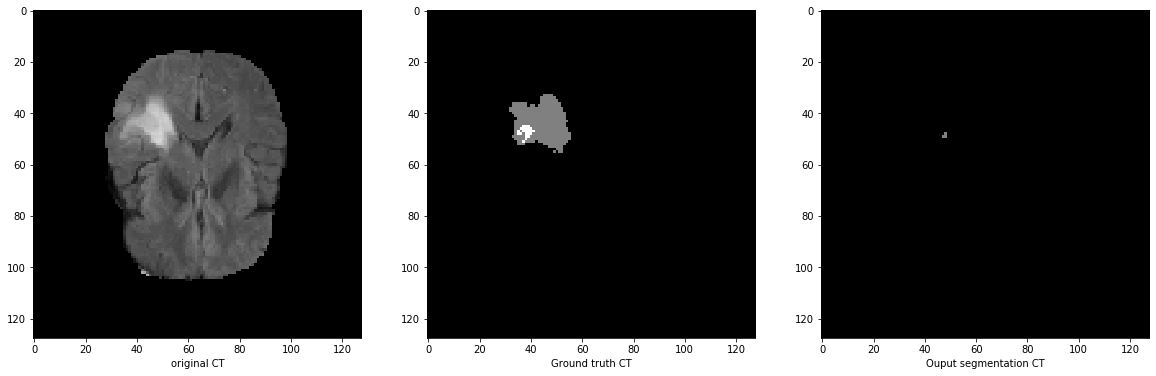

In [63]:
# flair + t1ce CT model result

image_seg_h = data_3d.shape[2]//input_height
image_seg_w = data_3d.shape[3]//input_width

print(image_seg_h)
print(image_seg_w)
for i in range(test_output.shape[1]//(image_seg_h*image_seg_w)):
    for j in range(image_seg_h):
        for k in range(image_seg_w):
            if k == 0:
                ww = test_output[0][i*(image_seg_h*image_seg_w)+j*image_seg_w+k]
            else:
                ww = np.concatenate((ww,test_output[0][i*(image_seg_h*image_seg_w)+j*image_seg_w+k]),axis = 2)
        if j == 0:
            hh = ww
        else:
            hh = np.concatenate((hh,ww), axis = 1)
    if i == 0:
        test_resized = hh
    else:
        test_resized = np.concatenate((test_resized,hh), axis = 0)

print(test_resized.shape)

num=1
slice_num=56
fig = plt.figure(figsize=(20, 20))
fig.add_subplot(1,3,1)
plt.imshow(data_3d[num][slice_num],cmap=pylab.cm.gray,vmin = 0,vmax = 1)
plt.xlabel('original CT')
fig.add_subplot(1,3,2)
plt.imshow(resize_nii_label[num][slice_num],cmap=pylab.cm.gray,vmin = 0,vmax = 1)
plt.xlabel('Ground truth CT')
fig.add_subplot(1,3,3)
plt.imshow(test_output[num][slice_num],cmap=pylab.cm.gray,vmin = 0,vmax = 1)
plt.xlabel('Ouput segmentation CT')
plt.show()

In [33]:
np.where(test_output[4][60]!=0)

(array([], dtype=int64), array([], dtype=int64))

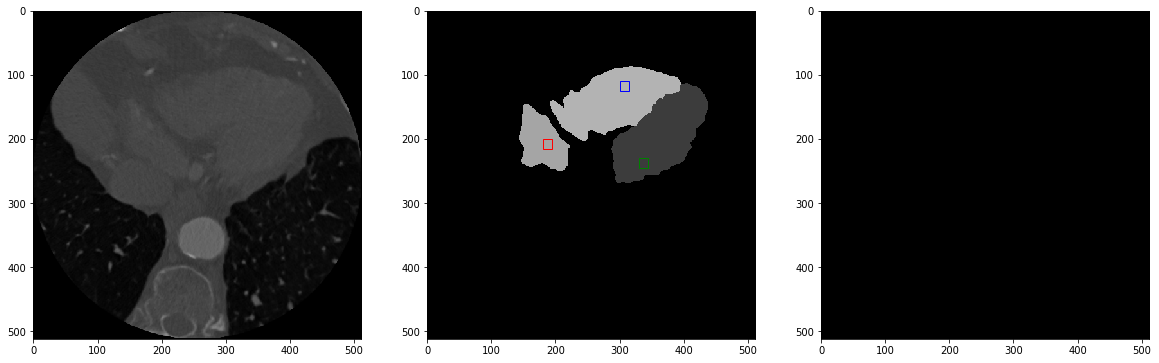

1770.0 -1024.0
600 0
red ROI 550.0 0.0
red ROI 0.0 0.0
blue ROI 600.0 0.0
blue ROI 0.0 0.0
green ROI 205.0 0.0
green ROI 0.0 0.0


In [32]:
t1 = 100
ROIrx = 180
ROIry = 200
ROIbx = 300
ROIby = 110
ROIgx = 330
ROIgy = 230
ROIs = 15

fig=plt.figure(figsize=(20,10))
fig.add_subplot(1,3,1)
plt.imshow(norm_nii_CT[t1],cmap = plt.cm.gray,vmin= 0,vmax = 1)
fig.add_subplot(1,3,2)
rect = patches.Rectangle((ROIrx,ROIry),ROIs,ROIs,linewidth=1,edgecolor='r',facecolor='none')
plt.gca().add_patch(rect)
rect = patches.Rectangle((ROIbx,ROIby),ROIs,ROIs,linewidth=1,edgecolor='b',facecolor='none')
plt.gca().add_patch(rect)
rect = patches.Rectangle((ROIgx,ROIgy),ROIs,ROIs,linewidth=1,edgecolor='g',facecolor='none')
plt.gca().add_patch(rect)
plt.imshow(nii_label[t1]/850,cmap = plt.cm.gray,vmin= 0,vmax = 1)
fig.add_subplot(1,3,3)
plt.imshow(test_resized[t1]/850,cmap = plt.cm.gray,vmin= 0,vmax = 1)
plt.show()




print(np.max(nii_CT[t1]),np.min(nii_CT[t1]))
print(np.max(nii_label[t1]),np.min(nii_label[t1]))

print("red ROI",np.mean(nii_label[t1,ROIry:ROIry+ROIs,ROIrx:ROIrx+ROIs]),
      np.std(nii_label[t1,ROIry:ROIry+ROIs,ROIrx:ROIrx+ROIs]))
print("red ROI",np.mean(test_resized[t1,ROIry:ROIry+ROIs,ROIrx:ROIrx+ROIs]),
      np.std(test_resized[t1,ROIry:ROIry+ROIs,ROIrx:ROIrx+ROIs]))
print("blue ROI",np.mean(nii_label[t1,ROIby:ROIby+ROIs,ROIbx:ROIbx+ROIs]),
      np.std(nii_label[t1,ROIby:ROIby+ROIs,ROIbx:ROIbx+ROIs]))
print("blue ROI",np.mean(test_resized[t1,ROIby:ROIby+ROIs,ROIbx:ROIbx+ROIs]),
      np.std(test_resized[t1,ROIby:ROIby+ROIs,ROIbx:ROIbx+ROIs]))
print("green ROI",np.mean(nii_label[t1,ROIgy:ROIgy+ROIs,ROIgx:ROIgx+ROIs]),
      np.std(nii_label[t1,ROIgy:ROIgy+ROIs,ROIgx:ROIgx+ROIs]))
print("green ROI",np.mean(test_resized[t1,ROIgy:ROIgy+ROIs,ROIgx:ROIgx+ROIs]),
      np.std(test_resized[t1,ROIgy:ROIgy+ROIs,ROIgx:ROIgx+ROIs]))

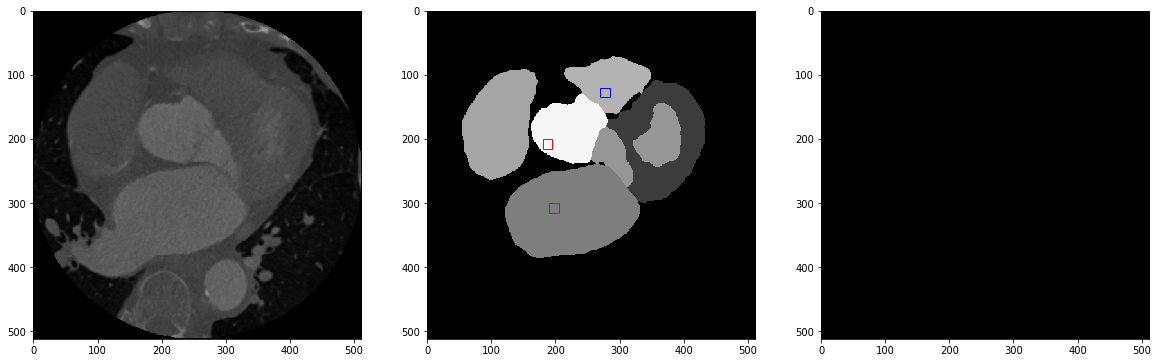

1508.0 -1024.0
820 0
red ROI 820.0 0.0
red ROI 0.0 0.0
blue ROI 600.0 0.0
blue ROI 0.0 0.0
green ROI 420.0 0.0
green ROI 0.0 0.0


In [33]:
t2 = 200
ROIrx = 180
ROIry = 200
ROIbx = 270
ROIby = 120
ROIgx = 190
ROIgy = 300
ROIts = 15

fig=plt.figure(figsize=(20,10))
fig.add_subplot(1,3,1)
plt.imshow(norm_nii_CT[t2],cmap = plt.cm.gray,vmin= 0,vmax = 1)
fig.add_subplot(1,3,2)
rect = patches.Rectangle((ROIrx,ROIry),ROIs,ROIs,linewidth=1,edgecolor='r',facecolor='none')
plt.gca().add_patch(rect)
rect = patches.Rectangle((ROIbx,ROIby),ROIs,ROIs,linewidth=1,edgecolor='b',facecolor='none')
plt.gca().add_patch(rect)
rect = patches.Rectangle((ROIgx,ROIgy),ROIs,ROIs,linewidth=1,edgecolor='g',facecolor='none')
plt.gca().add_patch(rect)
plt.imshow(nii_label[t2]/850,cmap = plt.cm.gray,vmin= 0,vmax = 1)
fig.add_subplot(1,3,3)
plt.imshow(test_resized[t2]/850,cmap = plt.cm.gray,vmin= 0,vmax = 1)
plt.show()




print(np.max(nii_CT[t2]),np.min(nii_CT[t2]))
print(np.max(nii_label[t2]),np.min(nii_label[t2]))

print("red ROI",np.mean(nii_label[t2,ROIry:ROIry+ROIs,ROIrx:ROIrx+ROIs]),
      np.std(nii_label[t2,ROIry:ROIry+ROIs,ROIrx:ROIrx+ROIs]))
print("red ROI",np.mean(test_resized[t2,ROIry:ROIry+ROIs,ROIrx:ROIrx+ROIs]),
      np.std(test_resized[t2,ROIry:ROIry+ROIs,ROIrx:ROIrx+ROIs]))
print("blue ROI",np.mean(nii_label[t2,ROIby:ROIby+ROIs,ROIbx:ROIbx+ROIs]),
      np.std(nii_label[t2,ROIby:ROIby+ROIs,ROIbx:ROIbx+ROIs]))
print("blue ROI",np.mean(test_resized[t2,ROIby:ROIby+ROIs,ROIbx:ROIbx+ROIs]),
      np.std(test_resized[t2,ROIby:ROIby+ROIs,ROIbx:ROIbx+ROIs]))
print("green ROI",np.mean(nii_label[t2,ROIgy:ROIgy+ROIts,ROIgx:ROIgx+ROIts]),
      np.std(nii_label[t2,ROIgy:ROIgy+ROIts,ROIgx:ROIgx+ROIts]))
print("green ROI",np.mean(test_resized[t2,ROIgy:ROIgy+ROIts,ROIgx:ROIgx+ROIts]),
      np.std(test_resized[t2,ROIgy:ROIgy+ROIts,ROIgx:ROIgx+ROIts]))